In [1]:
# Sample connection
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Cleaning connection")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/08/24 04:44:18 WARN Utils: Your hostname, DESKTOP-L9KIK4G resolves to a loopback address: 127.0.1.1; using 172.17.255.189 instead (on interface eth0)
22/08/24 04:44:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/24 04:44:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from statsmodels.formula.api import ols, glm
# VectorAssembler creates new vectors from existing columns
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, MinMaxScaler, StandardScaler
from pyspark.ml.linalg import Vectors

from pyspark.ml.regression import LinearRegression

import pandas as pd
import numpy as np
import os

In [3]:
sdf = spark.read.parquet('../data/curated/final3/clean_dataset.parquet/')

# Spliting train and test

In [4]:
# set aside 15 days from 2019 to do our testing
# code: https://stackoverflow.com/questions/553303/generate-a-random-date-between-two-other-dates
import random
import time


def str_time_prop(start, end, time_format, prop):
    stime = time.mktime(time.strptime(start, time_format))
    etime = time.mktime(time.strptime(end, time_format))

    ptime = stime + prop * (etime - stime)

    return time.strftime(time_format, time.localtime(ptime))


def random_date(start, end, prop):
    return str_time_prop(start, end, '%Y-%m-%d %H', prop) + ':00:00'


random.seed(42)
test_dates = [[random_date(
    "2019-06-01 00", "2019-08-31 23", random.random())] for x in range(15)]

test_dates_df = spark.createDataFrame(test_dates, ["temp_date"]).select(F.col("temp_date"), F.to_timestamp(
    F.col("temp_date"), 'yyyy-MM-dd HH:mm:ss').alias("dt_truncated")).select(F.col('dt_truncated'))

test_dates_df.join(sdf, on=['dt_truncated'], how='left') \
    .dropDuplicates()\
    .write.mode('overwrite').parquet('../data/temp/test_set/test_data.parquet')

testing_sdf = spark.read.parquet('../data/temp/test_set/test_data.parquet')

# remove those lines from the fitting dataset
sdf.subtract(testing_sdf.select('pickup_datetime', 'PULocationID', 'PUWeekday', 'PUHour', 'PUMonth', 'PUDay', 'dt_truncated',
             'count', 'wnd', 'vis', 'tmp', 'dew', 'atm', 'cc')).write.mode('overwrite').parquet('../data/temp/train_set/train.parquet')


22/08/24 04:47:32 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Normalising and one-hot-encoding the data

In [5]:
testing_sdf = spark.read.parquet('../data/temp/test_set/test_data.parquet')
train_sdf = spark.read.parquet('../data/temp/train_set/train.parquet')


In [6]:
onehotencoder = OneHotEncoder(
    inputCol='PULocationID',
    outputCol='location_vec'
    ).fit(train_sdf)

ohedata = onehotencoder.transform(train_sdf)

assembler = VectorAssembler(
    inputCols=['wnd', 'vis', 'tmp', 'dew', 'atm', 'cc', 'PUMonth', 'PUWeekday', 'PUDay', 'PUHour', 'location_vec'],
    outputCol='features')
model_sdf = assembler.transform(ohedata)

# Linear regression model

In [7]:
lm = LinearRegression(
    featuresCol='features', 
    labelCol='count'
).fit(model_sdf)

22/08/24 04:58:16 WARN Instrumentation: [cd2cc62a] regParam is zero, which might cause numerical instability and overfitting.


22/08/24 04:58:52 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/08/24 04:58:52 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/08/24 05:01:16 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
22/08/24 05:01:16 WARN Instrumentation: [cd2cc62a] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


## Evaluating model

In [8]:
print("Coefficients: " + str(lm.coefficients))
print("Intercept: " + str(lm.intercept))
trainingSummary = lm.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
# print(trainingSummary.residuals.count())
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print(trainingSummary.meanAbsoluteError)
print("r2: %f" % trainingSummary.r2) 

Coefficients: [0.7713354966634457,0.0008228327484598245,0.24462086561900973,0.2223106077658376,0.12321608655802135,-3.732873907258904e-06,-19.758227992553078,5.660308764068674,-0.10046171951916874,7.779693129873301,-366.87404027212295,-373.32650269236257,-374.26430200971055,-330.4746720852904,-216.51635380142838,-361.3046861697155,-362.6356882354914,-65.64239185836021,-377.05754941835676,-352.8084016052348,-305.08152100937633,-347.05230183721886,-360.9572314321824,-83.60149742416459,-250.96085052694497,-357.28575937854947,-324.4247781471349,-133.16494446883863,-275.9110526765935,-351.19570662458545,-314.4830191081533,-311.19420630606686,-299.36513246339234,-349.14512234087414,-292.4321829854059,-189.12779534714863,-245.94762925312642,-384.90272533700636,-325.2144489435256,-329.7866463200321,-370.3781416880967,-356.02284286571086,-321.5997126591389,-192.81603165356728,-356.4239628003172,-237.57514030265702,-119.30843494368868,-79.66070879086352,-346.6055402451403,-183.61059783991095,-28

In [9]:
error_rate_df = lm.transform(model_sdf.sample(0.05, 42))\
    .drop('pickup_datetime').dropDuplicates() \
    .select('PUHour', 'count', 'prediction') \
    .withColumn('error', F.abs(F.col('prediction') - F.col('count'))) \
    .toPandas()

error_rate_df

,PUHour,count,prediction,error
0,20,1497,1051.150086,445.849914
1,7,59,64.307216,5.307216
2,20,689,579.777289,109.222711
3,22,526,562.403917,36.403917
4,13,468,456.030144,11.969856
...,...,...,...,...
1032604,9,11,140.726507,129.726507
1032605,1,8,77.807363,69.807363
1032606,17,3,157.129178,154.129178
1032607,6,16,-24.290217,40.290217


In [10]:
error_rate_df.tail(5)

,PUHour,count,prediction,error
1032604,9,11,140.726507,129.726507
1032605,1,8,77.807363,69.807363
1032606,17,3,157.129178,154.129178
1032607,6,16,-24.290217,40.290217
1032608,7,36,-27.109196,63.109196


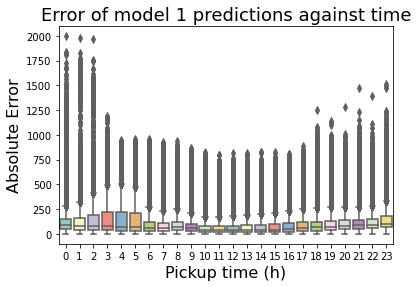

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 400
sns.boxplot(x="PUHour", y="error", data=error_rate_df, palette="Set3")

plt.xlabel('Pickup time (h)', fontsize=16)
plt.ylabel('Absolute Error', fontsize=16)
plt.title('Error of model 1 predictions against time', fontsize=18)

plt.savefig('../plots/model1_error_hour.jpeg')


In [12]:
residuals = trainingSummary.residuals.sample(0.05, 42).toPandas()

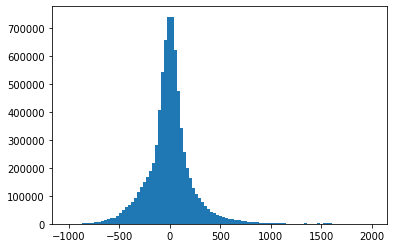

In [13]:
import matplotlib.pyplot as plt

plt.hist(residuals, bins=100)
plt.show()


# Linear reg v2

In [6]:
# # print('fitting OHE')
# onehotencoder = OneHotEncoder(
#     inputCol='PULocationID',
#     outputCol='location_vec'
# ).fit(train_sdf)

# # print('one hot encoding')
# onehotdata = onehotencoder.transform(train_sdf)

# assembler = VectorAssembler(
#     inputCols=['wnd', 'vis', 'tmp', 'dew', 'atm', 'cc', 'PUMonth',
#                'PUWeekday', 'PUDay', 'PUHour', 'location_vec'],
#     outputCol='features'
# )

# # print('assembling')
# assembled_sdf = assembler.transform(onehotdata)

# scaler = StandardScaler(
#     inputCol='features',
#     outputCol='scaledFeatures'
# )
# # print('fitting scaler')
# scalerModel = scaler.fit(
#     assembled_sdf.select("features")
# )        # TODO important variable

# # print('scaling')
# model_sdf = scalerModel.transform(assembled_sdf.filter(
#     (F.col('PUHour') > 5) & (F.col('PUHour') < 22)))


In [16]:
#sampled_model_sdf = model_sdf.sample(withReplacement=False, fraction=0.02, seed=42).toPandas()

In [ ]:
# fit = ols(
#     formula="count ~ wnd + tmp + dew + PUMonth + PUWeekday + PUHour + PULocationID",
#     #formula="count ~ wnd + vis + tmp + dew + atm + cc + PUMonth + PUWeekday + PUDay + PUHour + PULocationID",
#     data=sampled_model_sdf
# ).fit()
# fit.summary()

## Visualising errors

# Predicting
the pickup numbers per zone for those 15 hours we picked out earlier

In [23]:
testing_sdf = spark.read.parquet('../data/temp/test_set/test_data.parquet')

In [24]:
testing_sdf = onehotencoder.transform(testing_sdf)
testing_sdf = assembler.transform(testing_sdf)
#testing_sdf = scalerModel.transform(testing_sdf)
testing_sdf.show(5)


+-------------------+-------------------+------------+---------+------+-------+-----+-----+----+-------+-----+----+-------+---+-----------------+--------------------+
|       dt_truncated|    pickup_datetime|PULocationID|PUWeekday|PUHour|PUMonth|PUDay|count| wnd|    vis|  tmp| dew|    atm| cc|     location_vec|            features|
+-------------------+-------------------+------------+---------+------+-------+-----+-----+----+-------+-----+----+-------+---+-----------------+--------------------+
|2019-06-03 10:00:00|2019-06-03 10:33:30|       198.0|        2|    10|      6|    3|   16|46.0|16093.0|161.0|78.0|10110.0|2.0|(263,[198],[1.0])|(273,[0,1,2,3,4,5...|
|2019-06-03 10:00:00|2019-06-03 10:21:30|       196.0|        2|    10|      6|    3|   14|46.0|16093.0|161.0|78.0|10110.0|2.0|(263,[196],[1.0])|(273,[0,1,2,3,4,5...|
|2019-06-03 10:00:00|2019-06-03 10:10:51|       238.0|        2|    10|      6|    3|  273|46.0|16093.0|161.0|78.0|10110.0|2.0|(263,[238],[1.0])|(273,[0,1,2,3,4,5...

In [25]:
lm_predictions = lm.transform(testing_sdf)
lm_predictions.filter(F.col('dt_truncated') =='2019-08-07 17:00:00').drop('pickup_datetime').dropDuplicates().show(2700)#show(5)

+-------------------+------------+---------+------+-------+-----+-----+----+-------+-----+-----+-------+---+-----------------+--------------------+------------------+
|       dt_truncated|PULocationID|PUWeekday|PUHour|PUMonth|PUDay|count| wnd|    vis|  tmp|  dew|    atm| cc|     location_vec|            features|        prediction|
+-------------------+------------+---------+------+-------+-----+-----+----+-------+-----+-----+-------+---+-----------------+--------------------+------------------+
|2019-08-07 17:00:00|       126.0|        4|    17|      8|    7|    2|77.0|16093.0|289.0|217.0|10082.0|4.0|(263,[126],[1.0])|(273,[0,1,2,3,4,5...| 112.7045017845918|
|2019-08-07 17:00:00|        13.0|        4|    17|      8|    7|   98|77.0|16093.0|289.0|217.0|10082.0|4.0| (263,[13],[1.0])|(273,[0,1,2,3,4,5...| 339.4157757803483|
|2019-08-07 17:00:00|        61.0|        4|    17|      8|    7|   12|77.0|16093.0|289.0|217.0|10082.0|4.0| (263,[61],[1.0])|(273,[0,1,2,3,4,5...|  450.484834412449

In [26]:
# create a dataframe where dt_truncated = '2019-08-07 17:00:00', weather data is from the actual frame and contains every zone from 1 to 263
columns = ['dt_truncated', 'PULocationID', 'wnd', 'vis', 'tmp',
           'dew', 'atm', 'cc', 'PUMonth', 'PUWeekday', 'PUDay', 'PUHour']
data = [('2019-08-07 17:00:00', x, 46.0, 16093.0, 161.0,
         78.0, 10110.0, 2.0,  8, 4, 7, 17) for x in range(1, 264)]

rdd = spark.sparkContext.parallelize(data)
visualisation_sdf = rdd.toDF(columns)

visualisation_sdf = onehotencoder.transform(visualisation_sdf)
visualisation_sdf = assembler.transform(visualisation_sdf)
#visualisation_sdf = scalerModel.transform(visualisation_sdf)
visualisation_sdf.show(5)

+-------------------+------------+----+-------+-----+----+-------+---+-------+---------+-----+------+---------------+--------------------+
|       dt_truncated|PULocationID| wnd|    vis|  tmp| dew|    atm| cc|PUMonth|PUWeekday|PUDay|PUHour|   location_vec|            features|
+-------------------+------------+----+-------+-----+----+-------+---+-------+---------+-----+------+---------------+--------------------+
|2019-08-07 17:00:00|           1|46.0|16093.0|161.0|78.0|10110.0|2.0|      8|        4|    7|    17|(263,[1],[1.0])|(273,[0,1,2,3,4,5...|
|2019-08-07 17:00:00|           2|46.0|16093.0|161.0|78.0|10110.0|2.0|      8|        4|    7|    17|(263,[2],[1.0])|(273,[0,1,2,3,4,5...|
|2019-08-07 17:00:00|           3|46.0|16093.0|161.0|78.0|10110.0|2.0|      8|        4|    7|    17|(263,[3],[1.0])|(273,[0,1,2,3,4,5...|
|2019-08-07 17:00:00|           4|46.0|16093.0|161.0|78.0|10110.0|2.0|      8|        4|    7|    17|(263,[4],[1.0])|(273,[0,1,2,3,4,5...|
|2019-08-07 17:00:00|      

In [27]:
predicted = lm.transform(visualisation_sdf).select(
    'PULocationID', 'prediction')
# predicted.sort('PULocationID')
# predicted.join(testing_sdf.drop('pickup_datetime').dropDuplicates(), on='PULocationID', how='fullouter')\
#     .filter(F.col('dt_truncated') == '2019-08-07 17:00:00').sort('PULocationID')
t_df = testing_sdf.filter(F.col('dt_truncated') == '2019-08-07 17:00:00').select('PULocationID', 'count').dropDuplicates().sort('PULocationID').toPandas()
pred_df = predicted.toPandas()

In [28]:
result = []
for prediction in pred_df.values.tolist():
    for actual in t_df.values.tolist():
        if prediction[0] == actual[0]:
            result.append([int(prediction[0]), int(actual[1]), prediction[1],  prediction[1] - int(actual[1])])
            break
    else:
        result.append([int(prediction[0]), 0, prediction[1], prediction[1]])

if not os.path.exists('../data/curated/visualisation/'):
    os.makedirs('../data/curated/visualisation/')
pd.DataFrame(result, columns=['PULocationID', 'actual', 'predicted', 'diff'])\
    .to_csv('../data/curated/visualisation/2019august.csv', index=False)
